# Going convolutional

## Imports

In [1]:
import pandas as pd, numpy as np, h5py
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'O device a ser utilizado será {device}')

O device a ser utilizado será cuda


## Pegando o arquivo HDF5

In [3]:
file = h5py.File('data/dataset.h5', 'r')

In [4]:
## treino
x_train = file['samples_train']
y_train = file['labels_train']
## validação
x_val = file['samples_val']
y_val = file['labels_val']
## teste
x_test = file['samples_test']

## Criando o dataset

In [5]:
class DigitData(Dataset):
    
    def __init__(self, x, y, transforms=None):
        self.x, self.y, self.tfms = x, y, transforms
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        image = self.x[i].reshape((28,28,1))
        
        if self.tfms:
            image = self.tfms(image)
        else:
            image = image.transpose(2, 0, 1)
        
        return image, self.y[i]

In [6]:
ds_train = DigitData(x_train, y_train)
ds_val = DigitData(x_val, y_val)

### Checagem

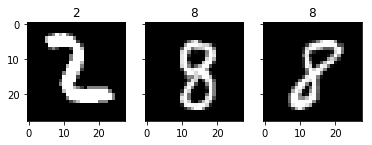

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(6,6))
for i, ax in enumerate(axs.flatten()):
    x, y = ds_val[i]
    ax.set_title(y)
    ax.imshow(x.squeeze(), cmap='gray')

In [26]:
x.shape

(1, 28, 28)

## Criando o Modelo

[convolução](https://github.com/vdumoulin/conv_arithmetic)

In [11]:
class ConvModel(nn.Module):
    
    def __init__(self, channels, classes):
        super().__init__()
        self.channels, self.classes = channels, classes
        
        self.conv1 = self.ConvBlock(1, 64)
        self.conv2 = self.ConvBlock(64, 128)
        self.conv3 = self.ConvBlock(128, 64)
        self.final = nn.Conv2d(64, 10, kernel_size=3, stride=1)
        
    def ConvBlock(self, in_channels, out_channels, ks=3, stride=1, pd=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, ks, stride, pd),
            nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, ks, stride, pd),
#             nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
    
    def forward(self, x):
        x = self.conv1(x)
#         print(x.shape)
        x = self.conv2(x)
#         print(x.shape)
        x = self.conv3(x)
#         print(x.shape)
        x = self.final(x)
#         print(x.shape)
        return x.squeeze_()

In [12]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))

In [13]:
model = ConvModel(1, 10)
model.apply(init_weights)
model.to(device)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1))
)

## Criando o DataLoader

In [9]:
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=True)

### Checando

In [54]:
x, y = next(iter(dl_val))

In [55]:
o = model(x.to(device))
o.shape

torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
torch.Size([64, 64, 3, 3])
torch.Size([64, 10, 1, 1])


torch.Size([64, 10])

## Métricas

In [17]:
def to_numpy(x): return x.cpu().detach().numpy()

In [10]:
def equals(predicted, targets):
    return sum(to_numpy(predicted) == to_numpy(targets))

In [11]:
def accuracy_and_loss(model, data_loader, loss_fn, iterations=500):
    model.eval()
    loss_tracker, counter, acc, szs = 0, 0, 0., 0
    for x, y in data_loader:
        out = model(x.to(device))
        loss_tracker += to_numpy(loss_fn(out, y.long().to(device)))
        acc += equals(out.argmax(1), y)
        szs += len(to_numpy(out))
        ## 
        counter += 1
        if counter >= iterations and iterations > 0: break
        del x, y, out
        gc.collect()
        torch.cuda.empty_cache()
    return loss_tracker/counter, acc/szs

## Definindo função de custo e acurácia

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

### Checando novamente

In [24]:
torch.cuda.empty_cache()

In [21]:
loss, acc = accuracy_and_loss(model, dl_val, loss_fn)

In [22]:
loss, acc

(2.435766235182557, 0.0902)

## Treinando

In [56]:
model.load_state_dict(torch.load('models/convolutional.pt'))

In [25]:
loss_train_tracker = []
loss_val_tracker = []
acc_train_tracker = []
acc_val_tracker = []

In [44]:
for ep in range(25):
    model.train()
    
    for x, y in dl_train:
        optimizer.zero_grad()
        out = model(x.to(device))
        loss = loss_fn(out, y.long().to(device))
        loss.backward()        
        optimizer.step()
            
        torch.cuda.empty_cache()
        gc.collect()
        
    loss_train, acc_train = accuracy_and_loss(model, dl_train, loss_fn, iterations=20)
    loss_val, acc_val = accuracy_and_loss(model, dl_val, loss_fn, iterations=20)
    
    loss_train_tracker.append(loss_train); acc_train_tracker.append(acc_train)
    loss_val_tracker.append(loss_val); acc_val_tracker.append(acc_val)
    
    print(f'Epoch {ep} Train: loss {loss_train:.5f} acc {acc_train:.5f} Val: loss {loss_val:.5f} acc {acc_val:.5f}')

Epoch 0 Train: loss 0.00027 acc 1.00000 Val: loss 0.03475 acc 0.99141
Epoch 1 Train: loss 0.00028 acc 1.00000 Val: loss 0.03477 acc 0.99141
Epoch 2 Train: loss 0.00013 acc 1.00000 Val: loss 0.03599 acc 0.99141


KeyboardInterrupt: 

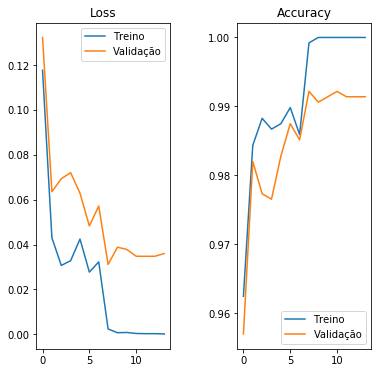

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
fig.subplots_adjust(wspace=0.5)
## loss
ax1.plot(loss_train_tracker)
ax1.plot(loss_val_tracker)
ax1.set_title('Loss')
ax1.legend(['Treino', 'Validação'])
## accuracy
ax2.plot(acc_train_tracker)
ax2.plot(acc_val_tracker)
ax2.set_title('Accuracy')
ax2.legend(['Treino', 'Validação'])

## Loss e Acurácia totais

In [30]:
loss, acc = accuracy_and_loss(model, dl_val, loss_fn)
print(loss, acc)

0.05064557530457461 0.9904


## Estimando o teste

In [31]:
bs = 64

In [45]:
predicts = []
model.eval()
for i in range(0, len(x_test), bs):
    start, end = i, min(i + bs, len(x_test))
    x = torch.tensor(x_test[start:end].reshape(-1, 1, 28,28)).to(device)
    out = model(x)
    predicts += to_numpy(out.argmax(1)).tolist()

## Colocando em um DataFrame

In [46]:
submission_conv = pd.DataFrame(data=predicts, columns=['Label'])
submission_conv.index.name = 'ImageId'
submission_conv.index += 1

In [47]:
submission_conv.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


## Submetendo no kaggle

In [48]:
submission_conv.to_csv('submissions/convolutional.csv')

<img src="images/convolutional.png">

In [50]:
torch.save(model.state_dict(), 'models/convolutional.pt')

## Olhando os erros

In [15]:
def predict(model, xset, bs=64):
    predicts = []
    model.eval()
    for i in range(0, len(xset), bs):
        start, end = i, min(i + bs, len(xset))
        x = torch.tensor(xset[start:end].reshape(-1, 1, 28,28)).to(device)
        out = model(x)
        predicts += to_numpy(out.argmax(1)).tolist()
    return predicts

In [18]:
pred_val = predict(model, x_val)

In [19]:
df_val = pd.DataFrame(data=y_val[:], columns=['Label'])
df_val['predicted'] = pred_val

In [20]:
df_val.head()

,Label,predicted
0,2,2
1,8,8
2,8,8
3,6,6
4,1,1


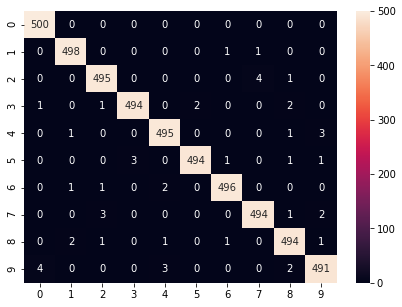

In [21]:
conf_mat = confusion_matrix(df_val['Label'], df_val['predicted'], labels=np.arange(10))
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat, annot=True, fmt='d')

### 0 vs 9

In [22]:
df_09 = df_val[(df_val['predicted'] == 0) &(df_val['Label'] == 9)]

In [23]:
df_09.head()

,Label,predicted
1234,9,0
2959,9,0
3244,9,0
3661,9,0


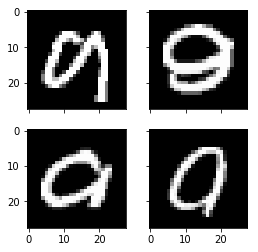

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(4,4))
for idx, ax in zip(df_09.index, axs.flatten()):
    ax.imshow(x_val[idx].reshape(28,28),cmap='gray')

# Inserindo data augmentation

## Transformadas

In [25]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomAffine(10, (0, 0.1), (0.95, 1.05)),
    torchvision.transforms.ToTensor(),
])

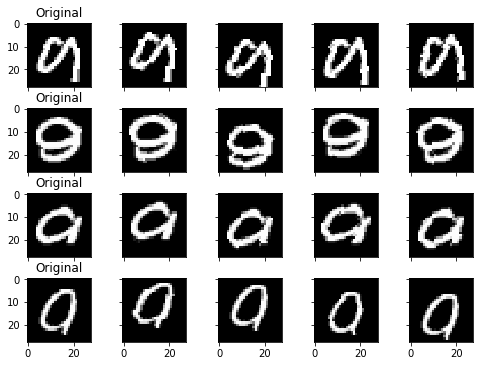

In [28]:
fig, axs = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(8,6))
fig.subplots_adjust(wspace=0.5)
for j, idx in enumerate(df_09.index):
    axs[j,0].imshow(x_val[idx].reshape(28,28),cmap='gray')
    axs[j,0].set_title('Original')
    for i in range(1,axs.shape[1]):
        axs[j,i].imshow(to_numpy(transforms(x_val[idx].reshape(28,28,1)).squeeze()), cmap='gray')

## Carregando o modelo

In [14]:
model.load_state_dict(torch.load('models/convolutional.pt'))

## Criando os novos datasets e DataLoaders

In [130]:
ds_train = DigitData(x_train, y_train, transforms=transforms)
ds_val = DigitData(x_val, y_val)

In [166]:
dl_train = DataLoader(ds_train, batch_size=512, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=256, shuffle=False)

## Redefinindo custo e otimizador

In [160]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 25)

## Continuando o treino

In [153]:
loss_train_tracker = []
loss_val_tracker = []
acc_train_tracker = []
acc_val_tracker = []

In [154]:
torch.cuda.empty_cache()

In [155]:
_, best_acc = accuracy_and_loss(model, dl_val, loss_fn)

In [167]:
%%time
for ep in range(25):
    
    model.train()
    for x, y in dl_train:
        optimizer.zero_grad()
        out = model(x.to(device))
        loss = loss_fn(out, y.long().to(device))
        loss.backward()        
        optimizer.step()
            
        torch.cuda.empty_cache()
        gc.collect()
        
    scheduler.step()
        
    loss_train, acc_train = accuracy_and_loss(model, dl_train, loss_fn, iterations=20)
    loss_val, acc_val = accuracy_and_loss(model, dl_val, loss_fn, iterations=-1)
    
    loss_train_tracker.append(loss_train); acc_train_tracker.append(acc_train)
    loss_val_tracker.append(loss_val); acc_val_tracker.append(acc_val)
    
    if acc_val > best_acc:
        best_acc = acc_val
        print('Salvo novos pesos')
        torch.save(model.state_dict(), 'models/data_aug.pt')
    
    print(f'Epoch {ep} Train: loss {loss_train:.5f} acc {acc_train:.5f} Val: loss {loss_val:.5f} acc {acc_val:.5f}')

Salvo novos pesos
Epoch 0 Train: loss 0.02294 acc 0.99170 Val: loss 0.03302 acc 0.99100
Epoch 1 Train: loss 0.02427 acc 0.99287 Val: loss 0.03230 acc 0.99060
Salvo novos pesos
Epoch 2 Train: loss 0.02122 acc 0.99414 Val: loss 0.03053 acc 0.99140
Epoch 3 Train: loss 0.01886 acc 0.99404 Val: loss 0.03279 acc 0.99100
Epoch 4 Train: loss 0.01910 acc 0.99404 Val: loss 0.03361 acc 0.99000
Salvo novos pesos
Epoch 5 Train: loss 0.02027 acc 0.99307 Val: loss 0.03238 acc 0.99160
Salvo novos pesos
Epoch 6 Train: loss 0.02257 acc 0.99277 Val: loss 0.03156 acc 0.99180
Epoch 7 Train: loss 0.02096 acc 0.99189 Val: loss 0.03286 acc 0.99160
Epoch 8 Train: loss 0.01473 acc 0.99590 Val: loss 0.03368 acc 0.99140
Epoch 9 Train: loss 0.01384 acc 0.99619 Val: loss 0.03310 acc 0.99180
Salvo novos pesos
Epoch 10 Train: loss 0.01803 acc 0.99404 Val: loss 0.03160 acc 0.99220
Salvo novos pesos
Epoch 11 Train: loss 0.01584 acc 0.99453 Val: loss 0.03391 acc 0.99240
Salvo novos pesos
Epoch 12 Train: loss 0.01536 acc

In [126]:
model.load_state_dict(torch.load('models/data_aug.pt'))

In [168]:
loss, acc = accuracy_and_loss(model, dl_val, loss_fn)

In [169]:
print(loss, acc)

0.03291085601667874 0.9926


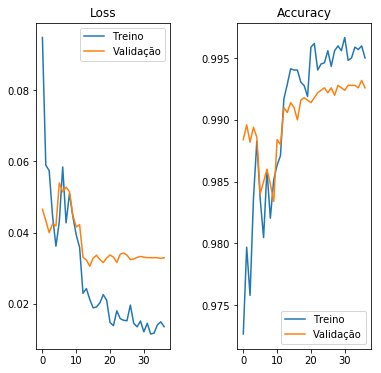

In [182]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
fig.subplots_adjust(wspace=0.5)
## loss
ax1.plot(loss_train_tracker)
ax1.plot(loss_val_tracker)
ax1.set_title('Loss')
ax1.legend(['Treino', 'Validação'])
## accuracy
ax2.plot(acc_train_tracker)
ax2.plot(acc_val_tracker)
ax2.set_title('Accuracy')
ax2.legend(['Treino', 'Validação'])

## Estimando o teste

In [172]:
pred = predict(model, x_test)
submission = pd.DataFrame(data=pred, columns=['Label'])
submission.index.name = 'ImageId'
submission.index += 1
submission.head()

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3


In [173]:
submission.to_csv('submissions/data_aug.csv')

<img src="images/data_aug.png">

## Ainda melhor?

In [176]:
class TTAData(Dataset):
    def __init__(self, x, transforms):
        self.x, self.tfms = x, transforms
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        image = self.x[i].reshape(28,28,1)
        image = self.tfms(image)
        return image

In [177]:
def predict_with_transforms(model, xset, transforms):
    data_loader = DataLoader(TTAData(xset, transforms), batch_size=128)
    predicts = []
    model.eval()
    for x in data_loader:
        out = model(x.to(device))
        predicts += to_numpy(out.argmax(1)).tolist()
    return predicts

In [195]:
df_val_tta = pd.DataFrame(data=y_val[:], columns=['Label'])
for i in range(11):
    df_val_tta[f'pred_{i}'] = predict_with_transforms(model, x_val, transforms)

In [196]:
df_val_tta.head()

,Label,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10
0,2,2,2,2,2,2,2,2,2,2,2,2
1,8,8,8,8,8,8,8,8,8,8,8,8
2,8,8,8,8,8,8,8,8,8,8,8,8
3,6,6,6,6,6,6,6,6,6,6,6,6
4,1,1,1,1,1,1,1,1,1,1,1,1


In [197]:
df_val_tta['predicted'] = [df_val_tta.iloc[i, 1:].mode()[0] for i in range(len(df_val_tta))]

In [198]:
print(accuracy_score(df_val_tta['Label'], df_val_tta['predicted']))

0.9928


### Para o teste

In [199]:
df_test_tta = pd.DataFrame()
for i in range(11):
    df_test_tta[f'pred_{i}'] = predict_with_transforms(model, x_test, transforms)

In [200]:
df_test_tta['predicted'] = [df_test_tta.iloc[i, 1:].mode()[0] for i in range(len(df_test_tta))]

In [201]:
df_test_tta.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,predicted
0,2,2,2,2,2,2,2,2,2,2,2,2
1,0,0,0,0,0,0,0,0,0,0,0,0
2,9,9,9,9,9,9,9,9,9,9,9,9
3,0,0,0,0,9,0,0,0,0,0,0,0
4,3,3,3,3,3,3,3,3,3,3,3,3


In [202]:
submission = pd.DataFrame(data=df_test_tta['predicted'].values, columns=['Label'])
submission.index.name = 'ImageId'
submission.index += 1
submission.head()

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3


In [204]:
submission.to_csv('submissions/data_aug_tta.csv')

<img src="images/data_aug_tta.png">

# Observações

1. 5000 images não foram utilizadas
2. [MNIST](http://yann.lecun.com/exdb/mnist/)